<a href="https://colab.research.google.com/github/EnricoMiche1210760/toxic_comments_filter/blob/main/src/progetto_toxic_comments_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: Toxic Comment Filter

The goal of this project is to build a model able to filter user comments based on the degree of harmfulness of the language. The main points to be addressed are the following:
<br>

**1. Preprocess the text by removing the set of tokens that do not provide significant semantic contribution**<br><br>

**2. Transform the text corpus into sequences**<br><br>

**3. Build a Deep Learning model including recurrent layers for a multilabel classification task**<br><br>

**4. In prediction time, the model must return a vector containing a 1 or a 0 corresponding to each label present in the dataset (toxic, severe_toxic, obscene, threat, insult, identity_hate). <br>In this way, a non-harmful comment will be classified by a vector of only 0s [0,0,0,0,0,0]. On the contrary, a dangerous comment will have at least one 1 among the 6 labels.**

In [1]:
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
import process as pr
import json
import os
from keras.backend import clear_session
import models as md
import pickle
from tensorflow.keras.models import load_model
from models import EarlyStopping, BatchLogger, LSTM_model
import matplotlib.pyplot as plt
import plots as pl

from sklearn.model_selection import train_test_split
from models import weighted_binary_crossentropy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

COLAB = False
if "google.colab" in str(get_ipython()):
    COLAB = True
    print('Running on CoLab')

answer = ""
models_dir = ""
if COLAB:
  models_dir="./models"
else:
  models_dir="../models"

2024-06-30 11:17:05.516169: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-30 11:17:05.517949: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-30 11:17:05.542907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 11:17:05.542935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 11:17:05.543681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
if COLAB == True:
    BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
    storage_folder = "./"
else:
    BASE_URL = "../data/"
    storage_folder = BASE_URL
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

## Dataset
First of all we can analyze the dataset that we have to use for this project. The dataset is composed of 159571 comments and 8 columns. The columns are:
- **comment_text**: the text of the comment
<br>

- **toxic**: binary label that indicates if the comment is toxic
<br>

- **severe_toxic**: binary label that indicates if the comment is severely toxic
<br>

- **obscene**: binary label that indicates if the comment is obscene
<br>

- **threat**: binary label that indicates if the comment is a threat
<br>

- **insult**: binary label that indicates if the comment is an insult
<br>

- **identity_hate**: binary label that indicates if the comment is an identity hate
<br>

- **sum_injurious**: sum of the labels toxic, severe_toxic, obscene, threat, insult, identity_hate

In [3]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


We can check all the comments that have 2 labels set to 1. 

In [4]:
df[df['sum_injurious']==2]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,2
79,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0,2
86,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0,2
168,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...
159253,what do you mean \n\nwhy don't you keep your n...,1,0,1,0,0,0,2
159334,"Horse's ass \n\nSeriously, dude, what's that h...",1,0,1,0,0,0,2
159449,I think he is a gay fag!!!,1,0,0,0,0,1,2
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2


In [5]:
len(df)

159571

### Dataset preprocessing
The dataset is already clean, so we can start with the preprocessing of the text. We decided to remove the set of tokens that do not provide significant semantic contribution, plus the stopwords and the punctuation.
To remove stopwords and punctuation we use the library nltk, while to remove the set of tokens that do not provide significant semantic contribution we use the library spacy, loading the model 'en_core_web_sm'.
Since the corpus is very large, we also decided to remove words smaller than 3 characters. Finally the text is lemmatized and converted to lowercase.

In [6]:
df_text = np.array(df['comment_text'])
type(df_text)

nlp, eng_stopwords = pr.load_dictionary('en_core_web_sm', 'english', 'punkt', stopword=True)
preprocessed_text= pr.preprocess_text_and_store(df_text, doc_store="preprocessed_text.csv", path=storage_folder, 
                                                store=True, eng_stopwords=eng_stopwords, nlp=nlp, word_min_len=3, COLAB=COLAB)


numpy.ndarray

Comparing the original text with the preprocessed text we can see that the text is more readable and the information is more focused on the content of the comment. Moreover the text becomes more compact, reducing the size of the dataset.

In [7]:
df_text[0]
preprocessed_text[0]
len(df_text[0])
len(preprocessed_text[0])


"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired'

264

158

### Dataset brief statistics

Once we preprocess the dataset comments, we can analyze some statistics about the dataset. We can notice that there is all the combination of labels in the dataset, meaning that there is at least one comment:
- with all the labels set to 1
<br>

- with all the labels set to 0
<br>

- with only one label set to 1 (for each label)
<br>

- with two labels set to 1
<br>

- with three labels set to 1
<br>

- with four labels set to 1
<br>

- with five labels set to 1
<br>


<br>
We can also notice that the dataset is unbalanced, since the number of comments with all the labels set to 0 is much higher than the number of comments with at least one label set to 1. This is a common problem in multilabel classification tasks, and we will have to deal with it during the training of the model.
The unbalance is also visible in the distribution of the labels, where we can see that the label 'toxic' is the most frequent, while the label 'threat' is the least frequent.

In [8]:
df = df.drop(columns=['comment_text'])
df.head(5)
df['sum_injurious'].unique()


,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


array([0, 4, 1, 3, 2, 5, 6])

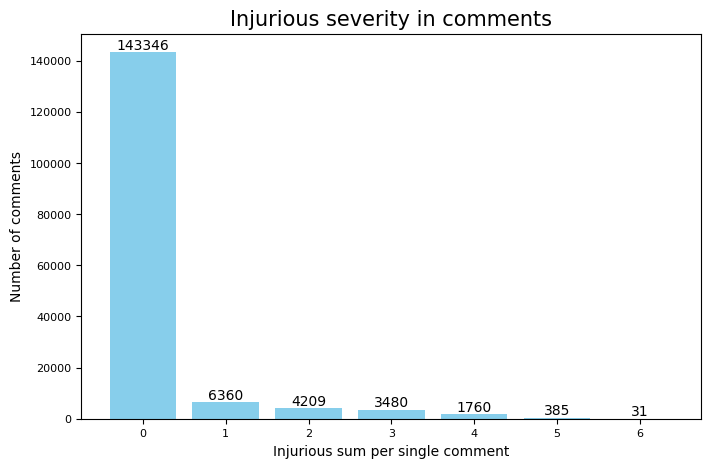

In [9]:
col_names = np.sort(df['sum_injurious'].unique())
comments_per_injurious = df['sum_injurious'].value_counts()

pl.plot_bar(col_names, comments_per_injurious, title='Injurious severity in comments', \
         xlabel='Injurious sum per single comment', ylabel='Number of comments', color='skyblue', \
            xticks_settings={'fontsize':8}, yticks_settings={'fontsize':8})

In [10]:
injurious = df.drop(columns=['sum_injurious'])
non_injurious = pd.Series(data=comments_per_injurious[0], index=["none"])
injurious_type_sum = pd.concat([injurious.sum(axis=0), non_injurious]).sort_values(ascending=False)
injurious_type_sum

none             143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
dtype: int64

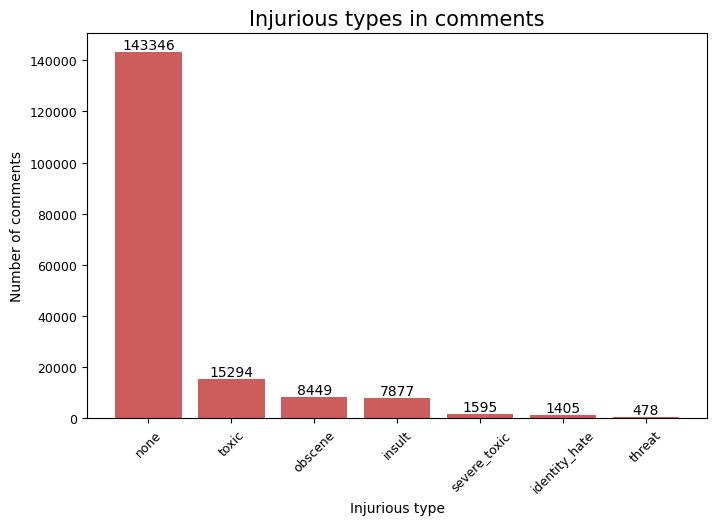

In [11]:
pl.plot_bar(injurious_type_sum.index, injurious_type_sum, title='Injurious types in comments', \
         xlabel='Injurious type', ylabel='Number of comments', color='indianred', \
            xticks_settings={'rotation':45, 'fontsize':9}, yticks_settings={'fontsize':9})

Observing the distribution behaviour with respect to the length of the comments, we can see that the distribution is similar for all the labels, with a median that oscillates between 57 and 71 words. The distribution is right-skewed, with a long tail of comments with a length greater than 1000 words.<br>
Moreover we can observe that for *severe_toxic* comments, we can notice that the 95-percentile is around 2036 words, while for the othes labels the 95-percentile is around 500 words.

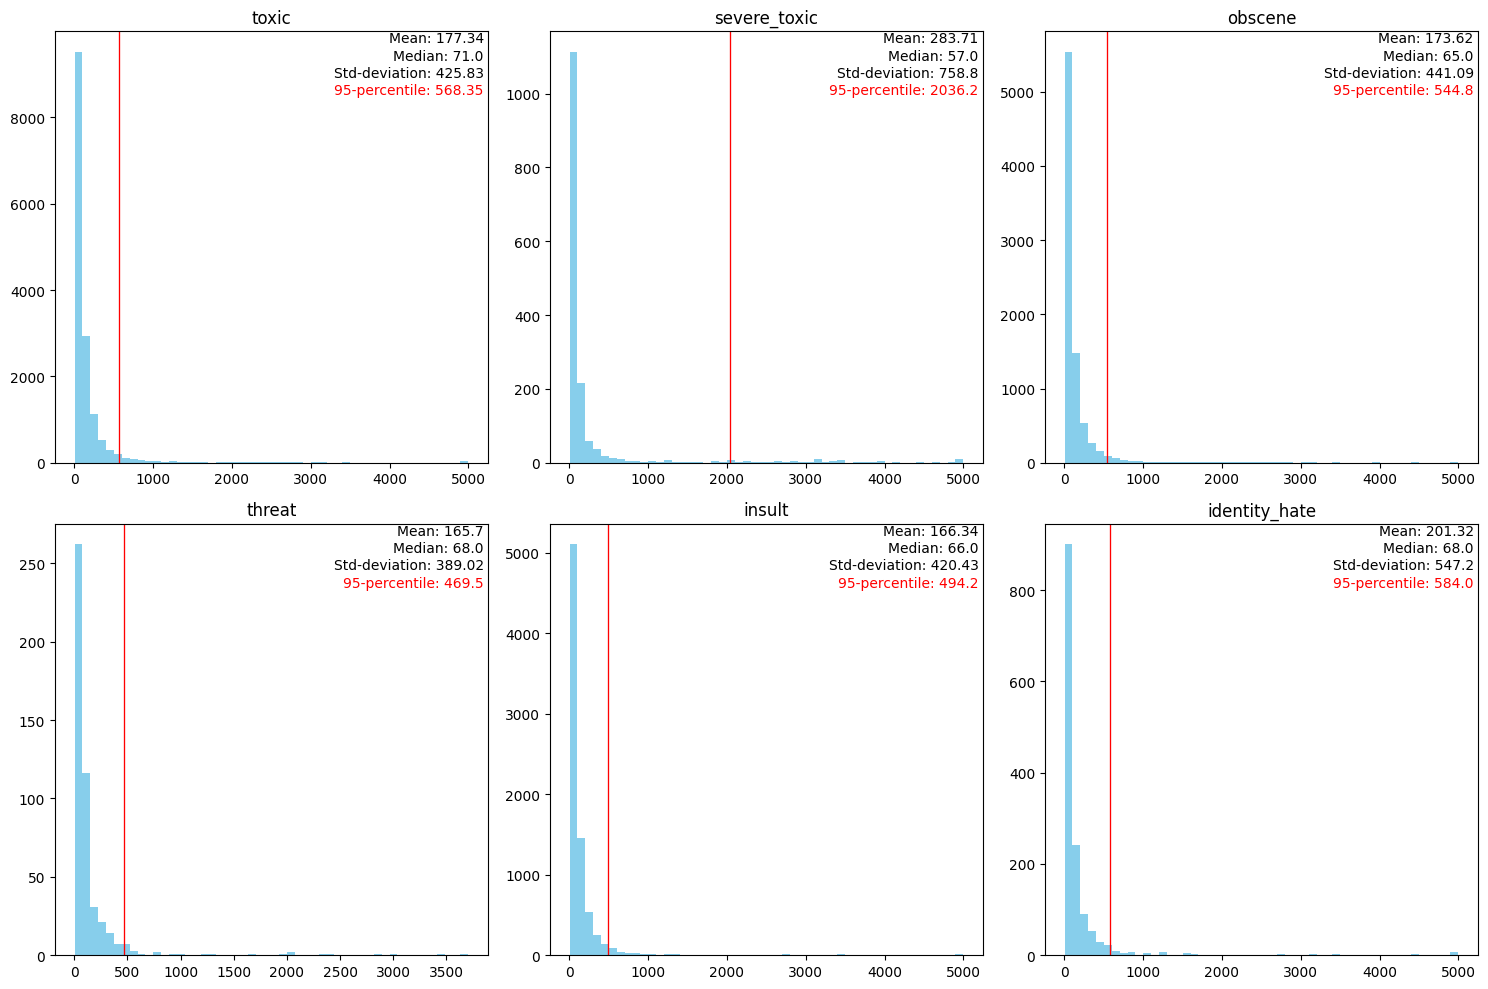

In [12]:
pl.plot_stats(dataframe=df, categories=injurious.columns, data=preprocessed_text)

In [13]:
injurious[0:10]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


### Dataset split
We split the dataset into training, validation and test set. For the firsts models we decided to use 40% of the dataset for the training set, 30% for the test set and 30% for the validation set. 
<br><br>We know that the proportion of training, validation and test set (40, 30, 30) is not very usual but, since the dataset is very large and we are limited in hardware resources available, we decided to select a leaner training set in order to be faster during the training phase.

In [14]:
def train_test_val_split(data, labels=None, test_size=0.2, val_size=0.1, random_state=42):
    if labels is None:
        data, labels = data
    corpus, X_test, train_labels, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(corpus, train_labels, test_size=val_size/(1-test_size), random_state=random_state)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_val = np.array(y_val)

    return X_train.astype(str).tolist(), X_test.astype(str).tolist(), X_val.astype(str).tolist(), y_train, y_test, y_val


In [15]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=injurious, test_size=0.3, val_size=0.3)


X_train[0:3]
y_train[0:3]

['writing biographies want create biography please first read wp blp follow guidance put front name way removed per guidelines read see wikipedia article wizard advises bit editing first',
 'asking already initiated another sock puppet investigation please wait verdict way proves wp hound orchestrated total attack wiki personality purpose eliminating wiki opinion latest dispute article albania alexikoua remove sourced consensual material cia world fact book official housing census united nations confirm already proven rows wp meat alexikoua addition noticed unethical act user alexikoua forward admin opinion comment removed talk page demonstrated purpose changing artificially established consensus denied alexikoua know yet wiki definition sure get trying say days block verdict account',
 'ok checked pome indeed right legend fate amrod telufinwë one burned ships amras pityafinwë ambarussa survived presumably still died third kinslaying follow pome strictly curufin fëanor fourth son caran

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [16]:
X_train, X_val, X_test, vocab_size, maxlen = pr.get_sequences(X_train, X_val, X_test, num_words=1000)

X_train.shape
y_train.shape

Words number: OrderedDict([('writing', 933), ('biographies', 331), ('want', 4648), ('create', 1096), ('biography', 296), ('please', 11964), ('first', 4370), ('read', 3263), ('wp', 4143), ('blp', 282), ('follow', 639), ('guidance', 86), ('put', 2474), ('front', 283), ('name', 4426), ('way', 4442), ('removed', 2632), ('per', 977), ('guidelines', 1313), ('see', 8559), ('wikipedia', 17657), ('article', 22694), ('wizard', 139), ('advises', 9), ('bit', 1316), ('editing', 3873), ('asking', 486), ('already', 2164), ('initiated', 47), ('another', 2622), ('sock', 477), ('puppet', 169), ('investigation', 180), ('wait', 455), ('verdict', 29), ('proves', 131), ('hound', 17), ('orchestrated', 4), ('total', 380), ('attack', 1172), ('wiki', 2035), ('personality', 96), ('purpose', 425), ('eliminating', 22), ('opinion', 1557), ('latest', 232), ('dispute', 747), ('albania', 68), ('alexikoua', 15), ('remove', 2137), ('sourced', 590), ('consensual', 10), ('material', 1416), ('cia', 85), ('world', 1948), ('

(63828, 1250)

(63828, 6)

## Utility functions and classes
We define here a couple of utility functions to:
- convert the probability output of the model to a binary output as required;ù
<br>

- search for a model already trained in the folder 'models' and load it if required by the user;ù
<br>

- stretch loss and accuracy values to the same length of the batch loss and validation, in order to plot them together;ù
<br>

- store information about model training in a dictionary.

<br>

Moreover, from *models.py*  we import the classes **EarlyStopping** and **BatchLogger** that we will use during the training of the model.
These classes are callbacks that we will use to stop the training of the model if the validation loss does not improve for a certain number of epochs and to have a more detailed visualization of the training loss and accuracy respectively.

In [17]:
def build_model(name, model, models_dir, optmizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
  fit = False
  if name in os.listdir(models_dir):
    answer = str(input(f"Found Keras model {name}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
      model.compile(optimizer=optmizer, loss=loss, metrics=metrics)
      fit = True
    elif callable(loss):
      custom_objects = {'loss': loss}
      model = load_model(models_dir+'/'+name, custom_objects=custom_objects)
    else:
      model = load_model(models_dir+'/'+name)
  else:
    print(f"Building {name} model")
    model.compile(optimizer=optmizer, loss=loss, metrics=metrics)
    fit = True
  return model, fit

In [18]:
def convert_probability_to_value(arr:np.array, threshold=.5):
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            arr[i][j] = 1 if arr[i][j] > threshold else 0
    return arr

In [19]:
def stretch_loss_accuracy(val_loss_per_epoch, val_accuracy_per_epoch, batch_log):
    stretch_loss = []
    stretch_accuracy = []

    for i in range(len(val_loss_per_epoch)):
        stretch_loss += [val_loss_per_epoch[i]]*int(len(batch_log.batch_loss) / len(val_loss_per_epoch))
        stretch_accuracy += [val_accuracy_per_epoch[i]]*int(len(batch_log.batch_accuracy) / len(val_accuracy_per_epoch))

    stretch_loss = np.array(stretch_loss)
    stretch_accuracy = np.array(stretch_accuracy)
    return stretch_loss, stretch_accuracy

In [20]:
def show_accuracy_precision_recall(measures, model_name, injurious, y_test, y_pred):
    measures[model_name] = {}

    for i in range(6):
        injurious_type = injurious[i] 
        true_positives = np.sum(y_pred[:,i] * y_test[:,i])
        false_positives = np.sum(y_pred[:,i] * (1-y_test[:,i]))
        false_negatives = np.sum((1-y_pred[:,i]) * y_test[:,i])
        measures[model_name][injurious_type+'_precision'] =  round(true_positives / (true_positives + false_positives), 2)
        measures[model_name][injurious_type+'_recall'] =  round(true_positives / (true_positives + false_negatives), 2)
    return measures    

In [21]:
early_stopping = EarlyStopping()
batch_log = BatchLogger()

## Model 1: LSTM
We build a first model using LSTM layers. LSTM layers are a type of recurrent neural network that are able to learn long-term dependencies in the data. We decided to use this type of layer because the comments are sequences of words and the order of the words is important to understand the meaning of the comment.
The model is composed of:
<br>

- an **Embedding** layer with an input dimension equal to the size of the vocabulary and an output dimension equal to 150
<br>

- a **Dropout** layer with a rate of 0.65 in order to avoid overfitting
<br>

- an **LSTM** layer with 150 units and the return_sequences parameter set to True
<br>

- a **GlobalMaxPooling1D** layer to reduce the dimensionality of the output of the LSTM layer
<br>

- another **Dropout** layer with a rate of 0.35
<br>

- a **Dense** layer with 6 units and Sigmoid activation function.
<br>

The model is compiled using the Adam optimizer and the binary crossentropy loss function. We decided to use the binary crossentropy loss function because we have a multilabel classification task and the labels are binary.

In [22]:
clear_session()

lstm_model_history="base_LSTM.pkl"
lstm_model_name = "LSTM_model.keras"
fit = False

lstm_model = LSTM_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

lstm_model, fit = build_model(
   lstm_model_name,
   lstm_model,
   models_dir,
   optmizer='adam',
   loss='binary_crossentropy',
   metrics=['accuracy']
)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 150)         13954350  
                                                                 
 dropout (Dropout)           (None, 1250, 150)         0         
                                                                 
 lstm (LSTM)                 (None, 1250, 50)          40200     
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                        

We decide to train the model for a maximum of 10 epochs, using a batch size of 32. We used the EarlyStopping callback to stop the training if the validation loss is greater than 0.97 after 4 epochs.
We also used a BatchLogger callback to have a more detailed visualization of the training loss and accuracy.
<br>

Once the model has been trained, we save it in the folder 'models'. We also save the history of the training and the loggers of the training and validation loss and accuracy; in this way we can load them later and visualize them.

In [23]:
if fit:
    lstm_history = lstm_model.fit(X_train, y_train,
                        epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])    
    pickle.dump(lstm_history, open(storage_folder+"/"+lstm_model_history, 'wb'))
    pickle.dump(batch_log, open(storage_folder+"/lstm_batch_log.pkl", 'wb'))
    if COLAB:
        lstm_model.save("./models/"+lstm_model_name)
    else:
        lstm_model.save("../models/"+lstm_model_name)
else:
    lstm_history = pickle.load(open(storage_folder+"/"+lstm_model_history, 'rb'))
    batch_log = pickle.load(open(storage_folder+"/lstm_batch_log.pkl", 'rb'))



Let see the history of the training of the model:

In [24]:
lstm_history.history

{'loss': [0.14665022492408752,
  0.09255949407815933,
  0.07610777020454407,
  0.07273226976394653,
  0.07089883089065552],
 'accuracy': [0.8185436129570007,
  0.9886569976806641,
  0.9944695234298706,
  0.9945164918899536,
  0.9944851994514465],
 'val_loss': [0.11808133870363235,
  0.07356411963701248,
  0.06966039538383484,
  0.06978040188550949,
  0.06821957230567932],
 'val_accuracy': [0.9937331676483154,
  0.9937958121299744,
  0.9938167333602905,
  0.9938167333602905,
  0.9938167333602905]}

As required by the project, we need to convert the output of the model to a binary output. We can see that the model is able to classify the comments correctly, returning a vector of 0s for non-harmful comments and a vector with at least one 1 for harmful comments. We decided to use a threshold of 0.35 to convert the probability output of the model to a binary output, since the dataset is very unbalanced.

In [25]:
y_pred = convert_probability_to_value(lstm_model.predict(X_test), threshold=.35)

1496/1496 [==============================] - 161s 108ms/step


### Results and plots:
In the next cell we can see results of precision, recall and accuracy for each label. The best recall is obtained for the label 'obsene', while the best precision is obtained for the label 'toxic'.<br>On the other hand we can notice that this model has poor performance in predicting the label 'threat' and 'identity_hate', where no true positive is found.

In [26]:
measures_dict = {}
measures_dict = show_accuracy_precision_recall(measures_dict, 'LSTM', injurious.columns, y_test, y_pred)

In [27]:
measures = pd.DataFrame(measures_dict)
measures

,LSTM
toxic_precision,0.83
toxic_recall,0.58
severe_toxic_precision,0.39
severe_toxic_recall,0.42
obscene_precision,0.79
obscene_recall,0.72
threat_precision,NaN
threat_recall,0.00
insult_precision,0.68
insult_recall,0.61


We plot these results in a confusion matrix.

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


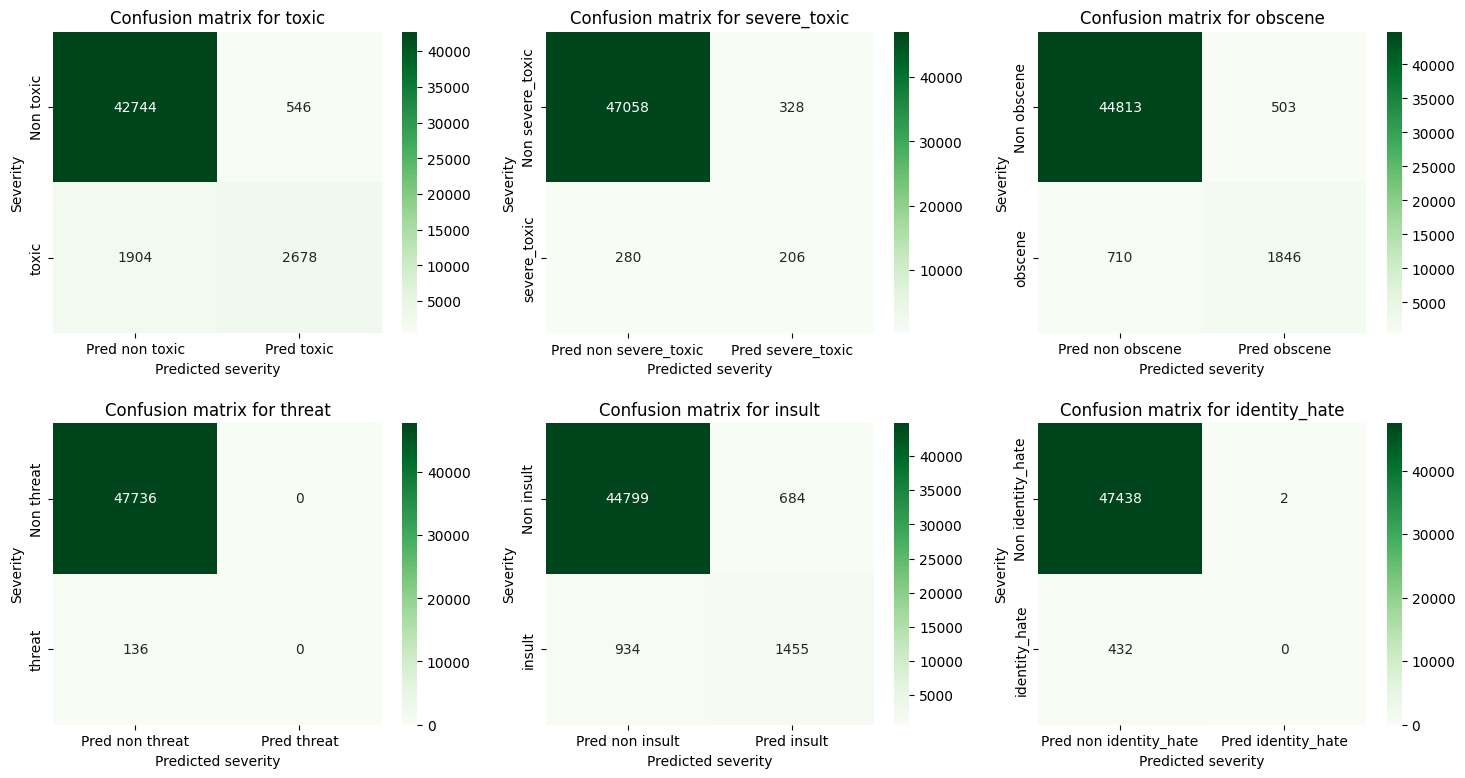

In [28]:
pl.print_confusion_matrix(y_test, y_pred, injurious.columns)

We can then plot the training and validation loss and accuracy, in order to understand if the model is overfitting or underfitting. We can see that the model is not overfitting, since the training and validation loss and accuracy are very close to each other. <br> On the other hand, validation accuracy is constantly at 0.99, probably suggesting that the model is not able to generalize well on the validation set.<br>
Moreover the recall is not very high, suggesting that the model is not able to classify correctly all the harmful comments but, for this case of study, is preferable to have a model with a high recall, in order to avoid that a harmful comment is classified as non-harmful.

In [29]:
val_loss_per_epoch = lstm_history.history['val_loss']
val_accuracy_per_epoch = lstm_history.history['val_accuracy']
stretch_loss, stretch_accuracy = stretch_loss_accuracy(val_loss_per_epoch, val_accuracy_per_epoch, batch_log)

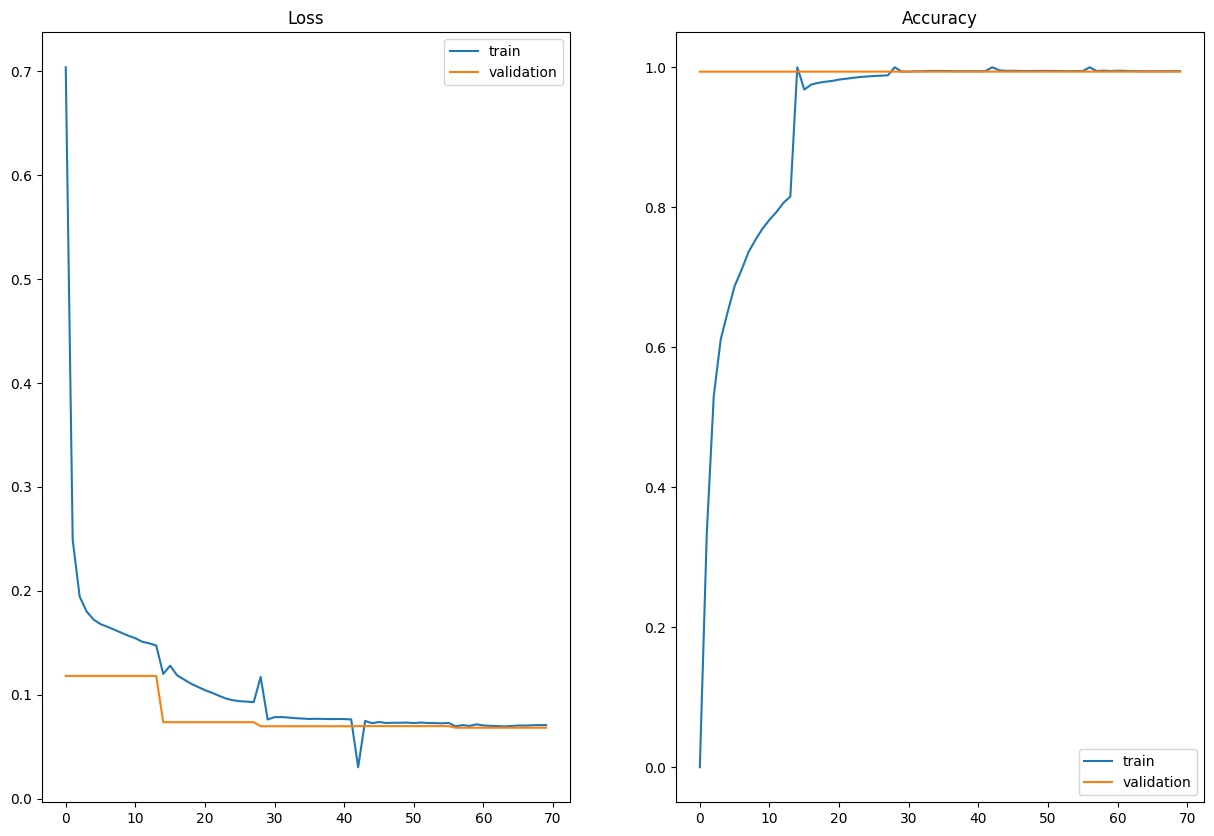

In [30]:
pl.plot_training_stats(batch_log.batch_loss, stretch_loss, batch_log.batch_accuracy, stretch_accuracy)

## Weighted loss function

In order to improve the performance of the model, we decided to use a weighted binary crossentropy loss function. We know that the dataset is unbalanced, so we decided to assign a weight to each label in order to penalize more the misclassification of the minority class. We used the formula:
<br>

$$
\text{loss} = -\frac{1}{NM} \sum_{i=1}^{N}\sum_{i=1}^{M} \left( w_{1,i} \cdot y_i \cdot \log(p_i) + w_{0,i} \cdot(1 - y_i) \cdot \log(1 - p_i) \right)
$$
<br>

where $N$ is the number of labels, $w_i$ is the weight assigned to the label $i$, $y_i$ is the true label and $p_i$ is the predicted label (see *models.py*).
The weights are calculated as the inverse of the frequency of the labels in the dataset, as you can see in the next cell.

In [31]:
w0 = [(1/np.sum(y_train.T[i] == 0)) * (len(y_train) /2) for i in range(len(y_train[0]))]
w1 = [(1/np.sum(y_train.T[i] == 1)) * (len(y_train) /2) for i in range(len(y_train[0]))] 
w0, w1

([0.553370786516854,
  0.5051202101897723,
  0.5278618567955142,
  0.5013825174385723,
  0.5258440295925261,
  0.5044096728307255],
 [5.184210526315789,
  49.32612055641422,
  9.472840605520927,
  181.32954545454547,
  10.173414089894804,
  57.193548387096776])

## LSTM model with weighted loss function

Once introduced the weighted loss function, we built again the LSTM model.
We also decided to use f1-score (together with accuracy) as a metric to evaluate the performance of the model, since it is a good metric for unbalanced datasets.
Just for recap, the model is composed of:
- an **Embedding** layer with an input dimension equal to the size of the vocabulary and an output dimension equal to 150
<br>

- a **Dropout** layer with a rate of 0.65 in order to avoid overfitting
<br>

- an **LSTM** layer with 150 units and the return_sequences parameter set to True
<br>

- a **GlobalMaxPooling1D** layer to reduce the dimensionality of the output of the LSTM layer
<br>

- another **Dropout** layer with a rate of 0.35
<br>

- a **Dense** layer with 6 units and Sigmoid activation function.
<br>

In [32]:
clear_session()

lstm_weight_hist_file="LSTM_with_weights.json"
lstm_weight_name = "LSTM_with_weights.keras"
fit = False

lstm_weight = LSTM_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

lstm_weight, fit = build_model(
   lstm_weight_name,
   lstm_weight,
   models_dir,
   optmizer='adam',
   loss=weighted_binary_crossentropy(w0, w1),
   metrics=[md.F1Score(), 'accuracy']
)

lstm_weight.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 150)         13954350  
                                                                 
 dropout (Dropout)           (None, 1250, 150)         0         
                                                                 
 lstm (LSTM)                 (None, 1250, 50)          40200     
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                        

Like before we train the model for a maximum of 10 epochs, using a batch size of 32 and we use the EarlyStopping and BatchLogger callbacks.

In [33]:
if fit:
    lstm_weight_hist = lstm_weight.fit(X_train, y_train,
                        epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])    
    json.dump(lstm_weight_hist.history, open(storage_folder+"/"+lstm_weight_hist_file, 'w'))
    batch_infos = {'batch_loss':batch_log.batch_loss, 'batch_accuracy':batch_log.batch_accuracy}
    json.dump(batch_infos, open(storage_folder+"/lstm_weight_batch_log.json", 'w'))
    if COLAB:
        lstm_weight.save("./models/"+lstm_weight_name)
    else:
        lstm_weight.save("../models/"+lstm_weight_name)
    lstm_weight_history = lstm_weight_hist.history
else:
    lstm_weight_history = json.load(open(storage_folder+"/"+lstm_weight_hist_file, 'r'))
    batch_infos = json.load(open(storage_folder+"/lstm_weight_batch_log.json", 'r'))
    batch_log.batch_loss = batch_infos['batch_loss']
    batch_log.batch_accuracy = batch_infos['batch_accuracy']


### Results and plots:
Observing the results of the model, we can see that the performance of the model has improved, as could be expected. The model grows in recall for all the labels, especially for the labels 'threat' and 'identity_hate'.<br> On the other hand, the precision of the model has decreased for all the labels, especially for labels 'toxic' and 'insult', where precision has halved.<br> For our purposes, the recall is more important than precision, since we want to avoid false negatives.

In [34]:
y_pred = convert_probability_to_value(lstm_weight.predict(X_test))  
measures_dict = show_accuracy_precision_recall(measures_dict, "LSTM_weight_loss", injurious.columns, y_test, y_pred)

1496/1496 [==============================] - 154s 102ms/step


In [35]:
pd.DataFrame(measures_dict)

,LSTM,LSTM_weight_loss
toxic_precision,0.83,0.43
toxic_recall,0.58,0.79
severe_toxic_precision,0.39,0.11
severe_toxic_recall,0.42,0.93
obscene_precision,0.79,0.45
obscene_recall,0.72,0.84
threat_precision,NaN,0.02
threat_recall,0.00,0.82
insult_precision,0.68,0.31
insult_recall,0.61,0.85


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


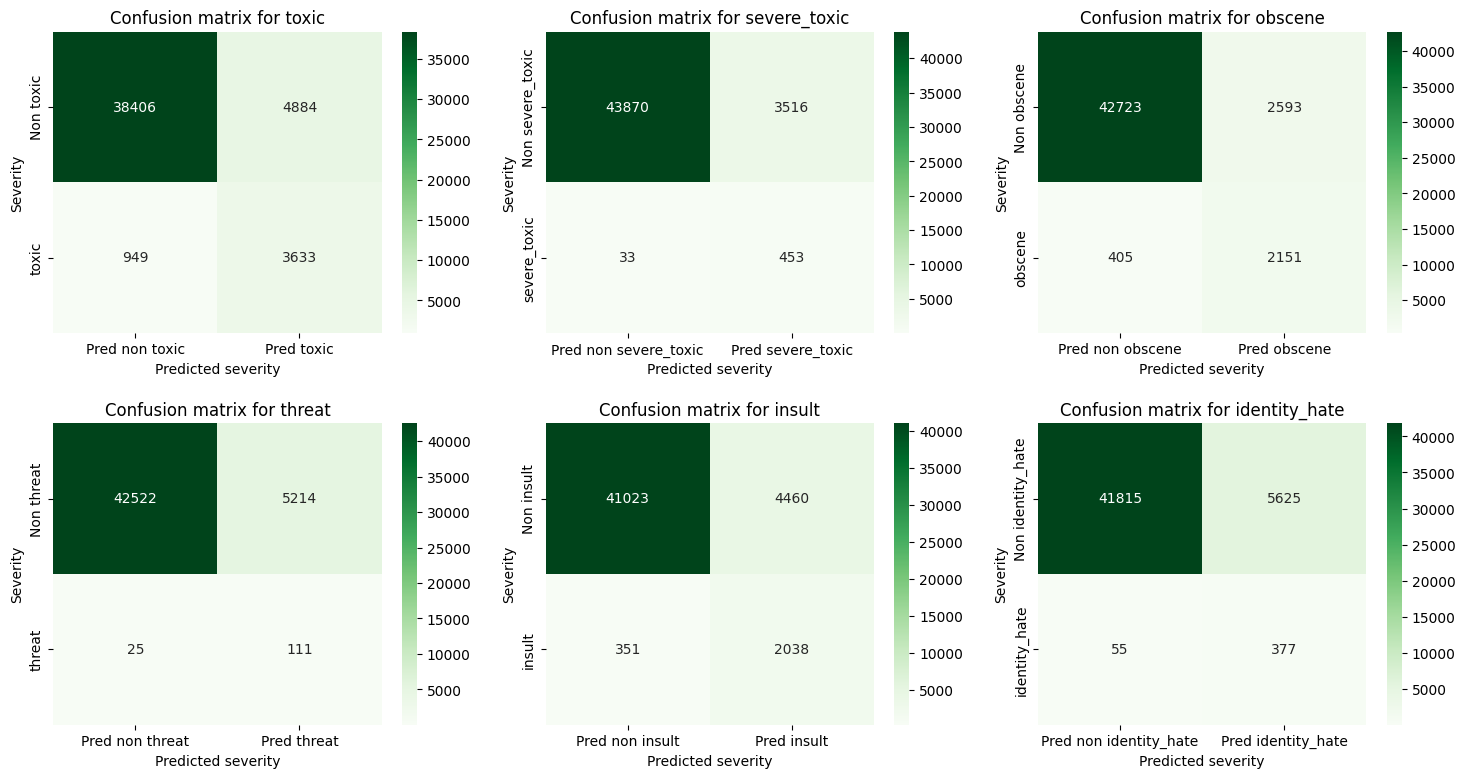

In [36]:
pl.print_confusion_matrix(y_test, y_pred, injurious.columns)

Below we can see the training and validation loss and accuracy, where we can see that the model is not overfitting, and the accuracy grew epoch by epoch.

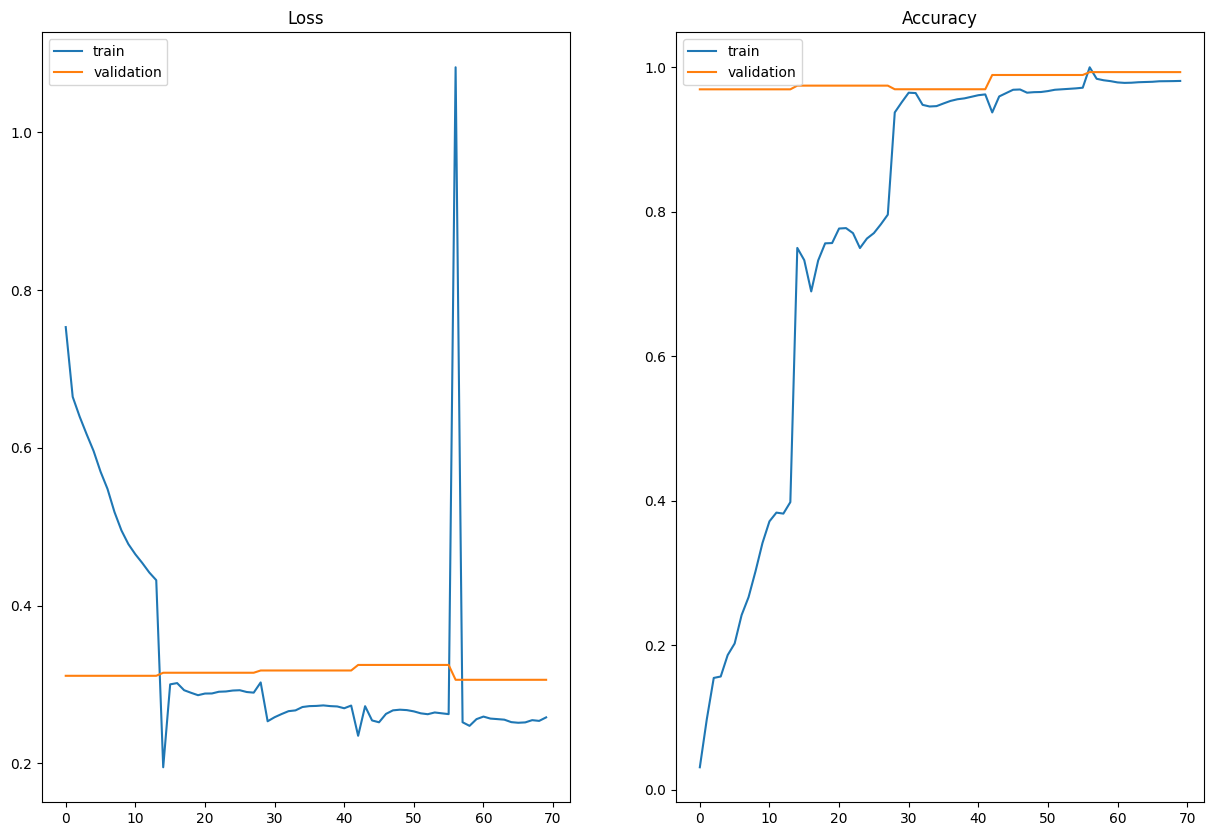

In [37]:
stretch_loss, stretch_accuracy = stretch_loss_accuracy(lstm_weight_history['val_loss'], lstm_weight_history['val_accuracy'], batch_log)
pl.plot_training_stats(batch_log.batch_loss, stretch_loss, batch_log.batch_accuracy, stretch_accuracy)

After these two models, we decided to build other two models, both containing an LSTM layer and a Convolutional layer, to see if we can improve the performance for the task.
Basically, the Convolutional layer is used to extract features from the text, while the LSTM layer is used to understand the sequence of the words.
We decided to use two different approaches, one using the weighted loss function we have seen before, and the other using the binary crossentropy loss function, rebalancing the dataset before the training.

## Model with LSTM and Convolutional layer
The model we are going to train is composed of:
- an **Embedding** layer with an input dimension equal to the size of the vocabulary and an output dimension equal to 150;
<br>

- a **Dropout** layer with a rate of 0.75;
<br>

- a bidirectional **LSTM** layer with 150 units and the return_sequences parameter set to True;
<br>

- a **Dropout** layer with a rate of 0.5;
<br>

- a **Conv1D** layer with64 filters, kernel size of 5 and ReLU activation function;
<br>

- a **GlobalMaxPooling1D** layer;
<br>

- another **Dropout** layer with a rate of 0.35;
<br>

- a **Dense** layer with 32 units and ReLU activation function;
<br>

- a **Dense** layer with 6 units and Sigmoid activation function.

In [38]:
clear_session()
cnn_model_keras = "cnn_model.keras"
cnn_model_history_file = "history_cnn.json"

fit = False

cnn_model = md.CNN_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

cnn_model, fit = build_model(
    cnn_model_keras,
    cnn_model,
    models_dir,
    optmizer='adam',
    loss=weighted_binary_crossentropy(w0, w1),
    metrics=[md.F1Score(), 'accuracy']
)
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 150)         13954350  
                                                                 
 dropout (Dropout)           (None, 1250, 150)         0         
                                                                 
 bidirectional (Bidirection  (None, 1250, 200)         200800    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1250, 200)         0         
                                                                 
 conv1d (Conv1D)             (None, 1246, 64)          64064     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                        

In [39]:
if fit:
    history_cnn = cnn_model.fit(X_train, y_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])

    json.dump(history_cnn.history, open(storage_folder+"/"+cnn_model_history_file, 'w'))
    batch_infos = {'batch_loss':batch_log.batch_loss, 'batch_accuracy':batch_log.batch_accuracy}
    json.dump(batch_infos, open(storage_folder+"/CNN_model_batch_log.json", 'w'))
    if COLAB:
        cnn_model.save("./models/"+cnn_model_keras)
    else:
        cnn_model.save("../models/"+cnn_model_keras)
    cnn_model_history = history_cnn.history
else:
    cnn_model_history = json.load(open(storage_folder+"/"+cnn_model_history_file, 'r'))
    batch_infos = json.load(open(storage_folder+"/CNN_model_batch_log.json", 'r'))
    batch_log.batch_loss = batch_infos['batch_loss']
    batch_log.batch_accuracy = batch_infos['batch_accuracy']


### Results and plots:
The CNN model with LSTM shows good performance, in particular regarding the recall of the labels.<br>
Results does not change much from the previous model, but we can see that both the recall and the precision of the labels 'identity_hate' and 'insult' has improved.
The trade-off between performance and computational cost hangs on the side of the model without the convolutional layer, which is slightly faster to train and has very similar performance.

1496/1496 [==============================] - 520s 347ms/step
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


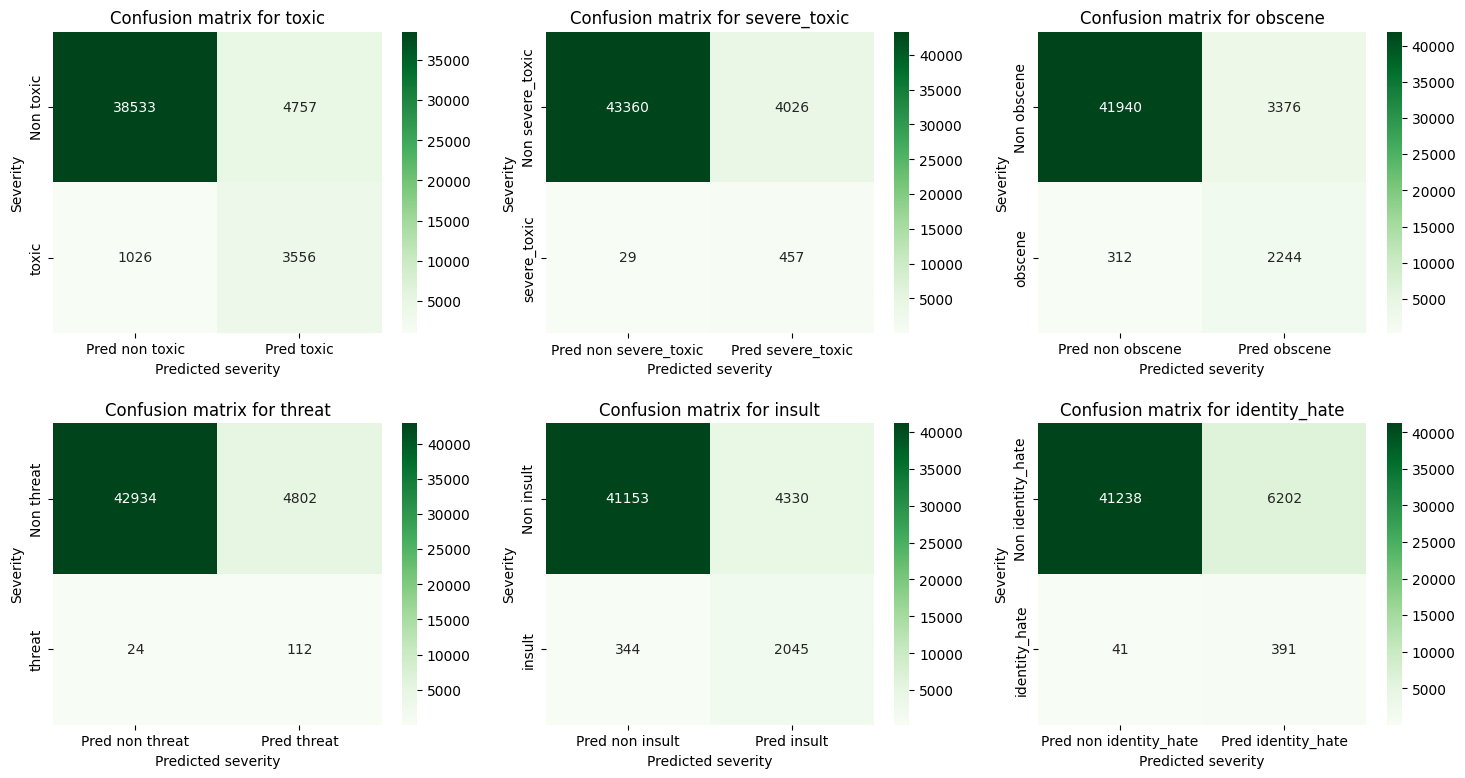

In [40]:
y_pred_cnn_with_w = convert_probability_to_value(cnn_model.predict(X_test), threshold=.40)
pl.print_confusion_matrix(y_test, y_pred_cnn_with_w, injurious.columns)

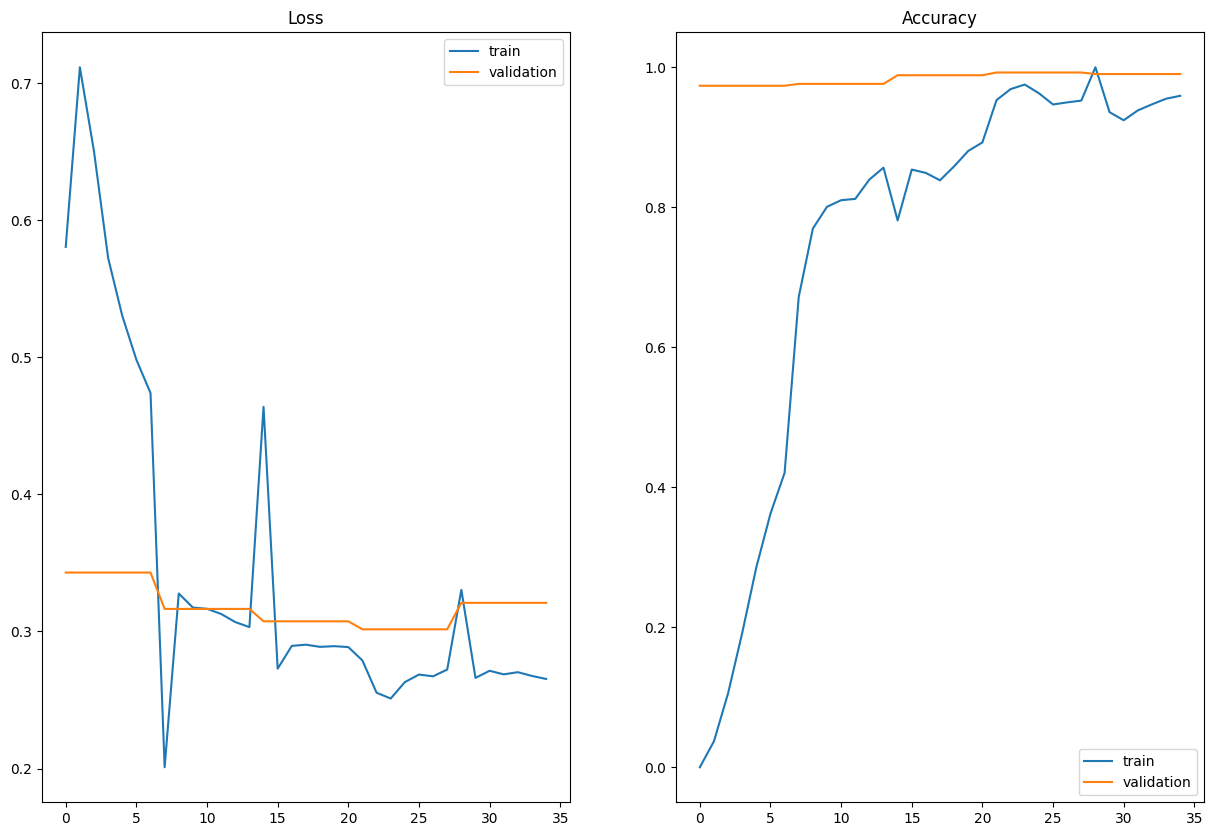

In [41]:
stretch_loss, stretch_accuracy = stretch_loss_accuracy(cnn_model_history['val_loss'], cnn_model_history['val_accuracy'], batch_log)
pl.plot_training_stats(batch_log.batch_loss, stretch_loss, batch_log.batch_accuracy, stretch_accuracy)

In [42]:
measures_dict = show_accuracy_precision_recall(measures_dict, "CNN_model", injurious.columns, y_test, y_pred_cnn_with_w)
pd.DataFrame(measures_dict)

,LSTM,LSTM_weight_loss,CNN_model
toxic_precision,0.83,0.43,0.43
toxic_recall,0.58,0.79,0.78
severe_toxic_precision,0.39,0.11,0.10
severe_toxic_recall,0.42,0.93,0.94
obscene_precision,0.79,0.45,0.40
obscene_recall,0.72,0.84,0.88
threat_precision,NaN,0.02,0.02
threat_recall,0.00,0.82,0.82
insult_precision,0.68,0.31,0.32
insult_recall,0.61,0.85,0.86


## Model with LSTM and Convolution with balanced dataset

The last model we are going to train is composed of:
- an **Embedding** layer with an input dimension equal to the size of the vocabulary and an output dimension equal to 256;
<br>

- a **Dropout** layer with a rate of 0.8;
<br>

- a **Conv1D** layer with64 filters, kernel size of 3 and ReLU activation function;
<br>

- a **BatchNormalization** layer to normalize the output of the Conv1D layer;
<br>

- a **MaxPooling1D** layer with a pool size of 2 in order to reduce the dimensionality of the output of the Conv1D layer;
<br>

- an **LSTM** layer with 150 units and the return_sequences parameter set to True;
<br>

- a **Dropout** layer with a rate of 0.6;
<br>

- a **Flatten** layer to flatten the output of the LSTM layer;

- a **Dense** layer with 128 units and ReLU activation function;

- a **Dense** layer with 6 units and Sigmoid activation function.

<br>

We decide to balance the dataset before the training, in order to avoid the problem of the unbalanced dataset. We mix a random over sampling of the minority class with a random under sampling of the majority class. We use for both a ratio of 0.65, in order to rebalance the dataset, maintaining a little unbalance in the dataset.

In [43]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=injurious, test_size=0.2, val_size=0.2)


def balance_training_set(X_train, y_train, random_over_sampling=0.5, random_under_sampling=0.5):
    indexes = [[],[],[],[],[],[],[]]
    for i in range(len(y_train)):
        indexes[np.cumsum(y_train[i])[-1]].append(i)
    
    print([sublist[0] for sublist in indexes])
    lenghts = [len(sublist) for sublist in indexes]
    id_class_with_max = lenghts.index(max(lenghts))

    if random_over_sampling > 0:
        for i in range(len(indexes)):
            if i != id_class_with_max:
                list_of_idx_to_add = np.random.choice(indexes[i], int(random_over_sampling*len(indexes[i])), replace=True)
                X_train = np.concatenate((X_train, [X_train[j] for j in list_of_idx_to_add]), axis=0)
                y_train = np.concatenate((y_train, [y_train[j] for j in list_of_idx_to_add]), axis=0)
    
    if random_under_sampling > 0:
        list_of_idx_to_remove = np.random.choice(indexes[id_class_with_max], int(random_under_sampling*len(indexes[id_class_with_max])), replace=False)
        X_train = np.delete(X_train, list_of_idx_to_remove, axis=0)
        y_train = np.delete(y_train, list_of_idx_to_remove, axis=0)

    return X_train, y_train

X_train, y_train = balance_training_set(X_train, y_train, random_over_sampling=0.65, random_under_sampling=0.65)
X_train, X_val, X_test, vocab_size, maxlen = pr.get_sequences(X_train, X_val, X_test, num_words=1500)

X_train.shape, y_train.shape



[0, 15, 17, 45, 116, 35, 3540]
Words number: OrderedDict([('polls', 18), ('close', 309), ('ontario', 24), ('pm', 54), ('bc', 56), ('hour', 103), ('coverage', 138), ('election', 122), ('results', 203), ('available', 334), ('people', 5411), ('still', 2128), ('voting', 60), ('language', 864), ('national', 422), ('library', 121), ('understand', 1244), ('may', 3597), ('person', 1936), ('charge', 99), ('front', 205), ('end', 679), ('security', 86), ('please', 7114), ('explain', 613), ('contact', 407), ('want', 3155), ('convert', 46), ('census', 69), ('griffiths', 1), ('valuations', 1), ('ino', 1), ('wiki', 1921), ('happy', 745), ('back', 2205), ('protected', 183), ('commissioned', 7), ('trustworthy', 13), ('microsoft', 42), ('company', 416), ('recieved', 20), ('secomd', 1), ('email', 384), ('talk', 8389), ('havent', 22), ('check', 983), ('inbox', 3), ('dicuss', 1), ('wiyh', 1), ('gmail', 3), ('friends', 350), ('anthony', 212), ('rodgers', 5), ('ph', 11), ('wiley', 4), ('protocol', 29), ('kno

((46109, 1250), (46109, 6))

In [44]:
clear_session()

cnn_model_2_keras = "cnn_model_2.keras"
cnn_model_2_history = "history_cnn_2.pkl"

fit = False

cnn_model_2 = md.CNN_model_2(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

cnn_model_2, fit = build_model(
    cnn_model_2_keras,
    cnn_model_2,
    models_dir,
    optmizer='adam',
    loss='binary_crossentropy',
    metrics=[md.F1Score(), 'accuracy']
)

cnn_model_2.summary()

([0.7429027164631199,
  0.5184514707205181,
  0.6095526413198668,
  0.5059917037947458,
  0.5997684643200916,
  0.5150462445824583],
 [1.5292186256301405,
  14.04905545399147,
  2.7820079642814046,
  42.22435897435897,
  3.0058018252933505,
  17.115441722345953])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 256)         17594880  
                                                                 
 dropout (Dropout)           (None, 1250, 256)         0         
                                                                 
 conv1d (Conv1D)             (None, 1250, 64)          49216     
                                                                 
 batch_normalization (Batch  (None, 1250, 64)          256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 625, 64)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                3

In [45]:
if fit:
    history_cnn_2 = cnn_model_2.fit(X_train, y_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])

    pickle.dump(history_cnn_2, open(storage_folder+"/"+cnn_model_2_history, 'wb'))
    pickle.dump(batch_log, open(storage_folder+"/lstm_batch_log.pkl", 'wb'))
    if COLAB:
        cnn_model_2.save("./models/"+cnn_model_2_keras)
    else:
        cnn_model_2.save("../models/"+cnn_model_2_keras)
else:
    history_cnn_2 = pickle.load(open(storage_folder+"/"+cnn_model_2_history, 'rb'))
    batch_log = pickle.load(open(storage_folder+"/lstm_batch_log.pkl", 'rb'))

Epoch 1/10
721/721 [==============================] - 467s 646ms/step - loss: 0.2060 - f1_score: 0.6259 - accuracy: 0.9514 - val_loss: 0.0761 - val_f1_score: 0.6996 - val_accuracy: 0.9940
Epoch 2/10
721/721 [==============================] - 466s 646ms/step - loss: 0.1642 - f1_score: 0.7193 - accuracy: 0.9788 - val_loss: 0.5573 - val_f1_score: 0.1956 - val_accuracy: 0.9596
Epoch 3/10
721/721 [==============================] - 413s 573ms/step - loss: 0.1568 - f1_score: 0.7316 - accuracy: 0.9794 - val_loss: 0.7855 - val_f1_score: 0.1540 - val_accuracy: 0.9845
Epoch 4/10
721/721 [==============================] - 421s 585ms/step - loss: 0.1525 - f1_score: 0.7337 - accuracy: 0.9757 - val_loss: 0.0696 - val_f1_score: 0.6891 - val_accuracy: 0.9940
Epoch 5/10
721/721 [==============================] - 447s 620ms/step - loss: 0.1485 - f1_score: 0.7404 - accuracy: 0.9789 - val_loss: 1.6015 - val_f1_score: 0.1210 - val_accuracy: 0.7765
Epoch 6/10
721/721 [==============================] - ETA: 0

In [46]:
history_cnn_2.history

{'loss': [0.20596913993358612,
  0.16416975855827332,
  0.1567576676607132,
  0.15250767767429352,
  0.14850690960884094,
  0.14564867317676544],
 'f1_score': [0.6258993744850159,
  0.7192773818969727,
  0.7315735816955566,
  0.7337062358856201,
  0.7404406666755676,
  0.743682324886322],
 'accuracy': [0.9513543844223022,
  0.9788327813148499,
  0.9794183373451233,
  0.975666344165802,
  0.9788761138916016,
  0.9788327813148499],
 'val_loss': [0.07608606666326523,
  0.5572766065597534,
  0.7855250239372253,
  0.06960947811603546,
  1.6015263795852661,
  0.06266961991786957],
 'val_f1_score': [0.6996355652809143,
  0.1955586075782776,
  0.15399445593357086,
  0.6891230940818787,
  0.12102055549621582,
  0.701569139957428],
 'val_accuracy': [0.9940465092658997,
  0.9596415162086487,
  0.9845209121704102,
  0.9939525127410889,
  0.7765244245529175,
  0.9940465092658997]}

### Results and plots:

The model with balanced dataset shows different performance with respect to the other models.<br>
In particular, the precision and recall for labels 'insult' is the best among all the models. The recall for 'toxic' is also very good, improving the performance of the previous models, and obtaining still a better precision compared to the other CNN model.<br>
For label 'obsene' we are able to preserve the good recall, improving the precision.<br>
On the other hand, the recall for the labels 'threat' and 'identity_hate' is very low, indicating that the model is not able to classify correctly these labels.


998/998 [==============================] - 73s 73ms/step
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


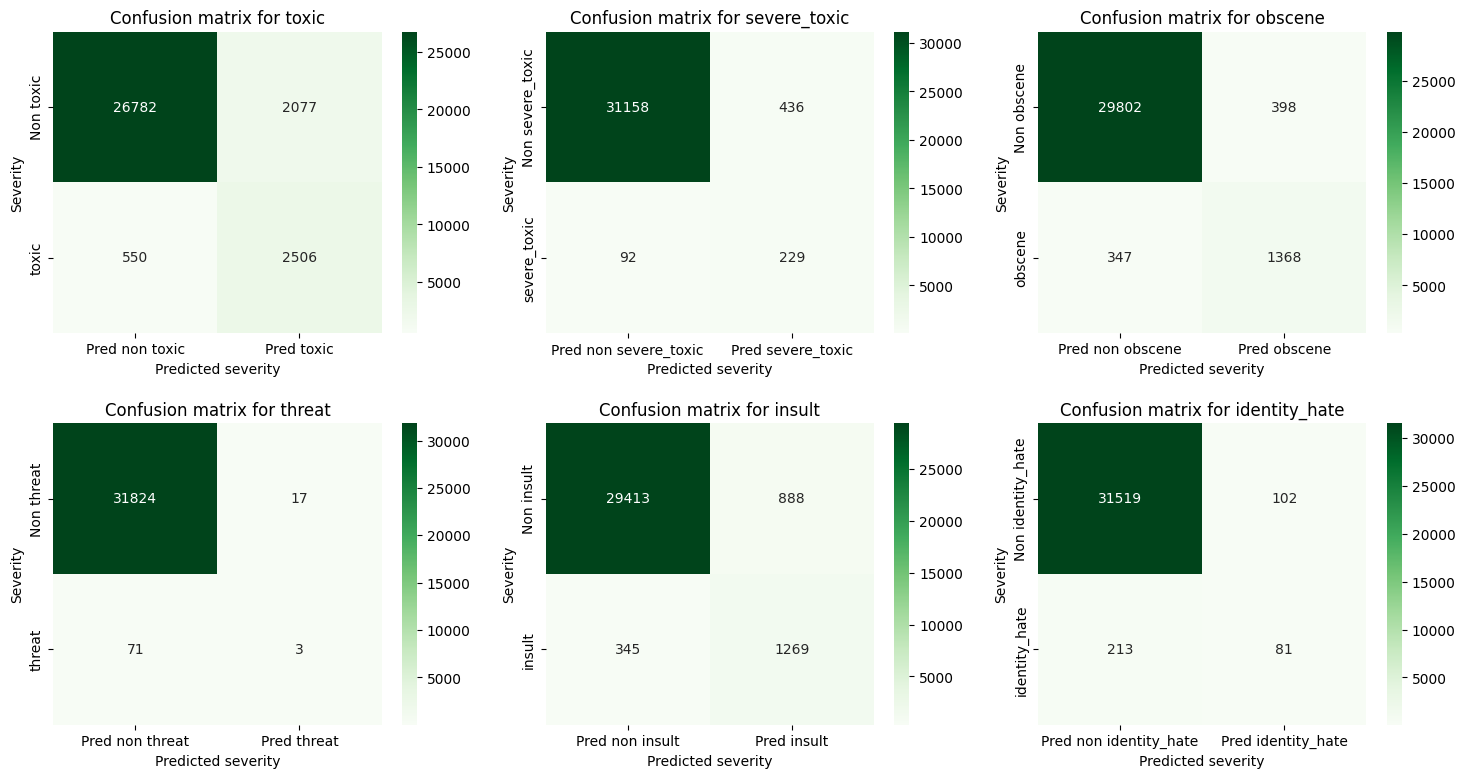

In [50]:
y_pred_cnn_2 = convert_probability_to_value(cnn_model_2.predict(X_test), threshold=.35)
pl.print_confusion_matrix(y_test, y_pred_cnn_2, injurious.columns)

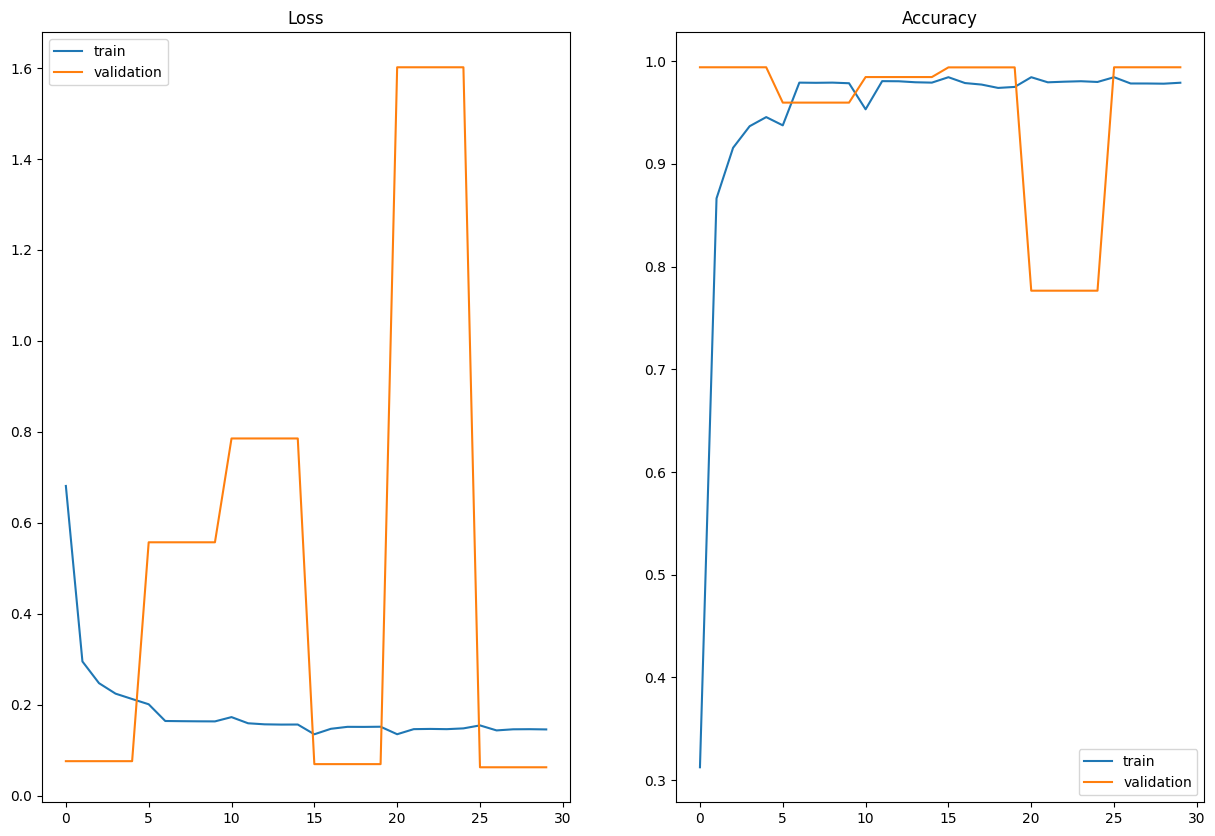

In [51]:
stretch_loss, stretch_accuracy = stretch_loss_accuracy(history_cnn_2.history['val_loss'], history_cnn_2.history['val_accuracy'], batch_log)
pl.plot_training_stats(batch_log.batch_loss, stretch_loss, batch_log.batch_accuracy, stretch_accuracy)

In [52]:
measures_dict = show_accuracy_precision_recall(measures_dict, "CNN_model_balanced", injurious.columns, y_test, y_pred_cnn_2)
pd.DataFrame(measures_dict)

,LSTM,LSTM_weight_loss,CNN_model,CNN_model_balanced
toxic_precision,0.83,0.43,0.43,0.55
toxic_recall,0.58,0.79,0.78,0.82
severe_toxic_precision,0.39,0.11,0.10,0.34
severe_toxic_recall,0.42,0.93,0.94,0.71
obscene_precision,0.79,0.45,0.40,0.77
obscene_recall,0.72,0.84,0.88,0.80
threat_precision,NaN,0.02,0.02,0.15
threat_recall,0.00,0.82,0.82,0.04
insult_precision,0.68,0.31,0.32,0.59
insult_recall,0.61,0.85,0.86,0.79


## Conclusions
In this project we built four models to classify the comments in the dataset. We started with a simple LSTM model, then we introduced a weighted loss function to penalize more the misclassification of the minority class. We then built two models with an LSTM layer and a Convolutional layer, one with the weighted loss function and the other with a balanced dataset. The LSTM model with weighted loss function and the LSTM model with Convolutional layer (and weight loss function) show similar performance, with the second model slightly better in terms of recall.<br>
The model with balanced dataset shows different performance, with a better precision and recall for the labels 'insult' and 'toxic', but a very low recall for the labels 'threat' and 'identity_hate'.<br>
The choice of the model depends on the trade-off between performance and computational cost, since the model with Convolutional layer is slower to train than the model with LSTM and weight loss function.<br>

We finally decided to use the LSTM model with weighted loss function as the final model, since it is faster to train and has similar performance to the other models, keeping in mind that the Convolutional layer model could be a good choice if we want to improve the performance of the model.